In [1]:
import c3d 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.transform import Rotation as R
from scipy.signal import correlate, correlation_lags
from sklearn.metrics import root_mean_squared_error
import os
import pickle
import seaborn as sn

with open('4.OPTO_IMU_Joint_Angles_aligned.pkl', 'rb') as f:
    OPTO, IMU = pickle.load(f)

joint_dict = {
    'Shoulder': {
        'axes names': ['Flexion/Extension', 'Internal/External Rotation', 'Abduction/Adduction'],
        'task names': ['Flexion', 'Abduction', 'Drinking', 'Box off Shelf', 'Circles']
    },
    
    'Elbow': {
        'axes names': ['Flexion/Extension', 'Pronation/Supination', 'Carrying angle'],
        'task names': ['Flexion', 'Pronation', 'Drinking', 'Box off Shelf', 'Circles']
    },
    
    'Wrist': {
        'axes names': ['Flexion/Extension', 'Internal/External Rotation', 'Radial/Ulnar Deviation'],
        'task names': ['Flexion', 'Deviation', 'Drinking', 'Box off Shelf', 'Circles']
    }
}

color_palette = {
    'Flexion/Extension': 'blue',
    'Internal/External Rotation':'green',
    'Pronation/Supination': 'green',
    'Abduction/Adduction': 'red',
    'Radial/Ulnar Deviation': 'red',
    'Carrying angle': 'red'
}



In [2]:
### Compute ROM error, RMSE and Offset for each task/axis and place it in a different dataframe for each joint ###

subject = 1 # this can be incremented by adding more subjects

dataframe_list = []
joints = list(joint_dict.keys())
dataframe_columns = ['Subject', 'Joint', 'Task', 'Axis', 'ROM OPTO', 'ROM IMU', 'ROM Error', 'RMSE', 'Offset']

for j in range(len(joints)):
    dataframe = pd.DataFrame(columns=dataframe_columns)
    tasks = joint_dict[joints[j]]['task names']
    axes =  joint_dict[joints[j]]['axes names']
    idx = 0
    
    for t in range(len(tasks)):
        for a in range(len(axes)):
            
            # select the correct data and compute the metrics
            opto = OPTO[t]['Right ' + joints[j]][:,a]
            imu = IMU[t]['Right ' + joints[j]][:,a]
            rom_opto = np.max(opto) - np.min(opto)
            rom_imu = np.max(imu) - np.min(imu)
            rom_error = rom_opto - rom_imu
            rmse = root_mean_squared_error(opto, imu)
            offset = np.mean(opto) - np.mean(imu)
            data_list = [rom_opto, rom_imu, rom_error, rmse, offset]
            
            # Store the information in the dataset
            dataframe.loc[idx, 'Subject'] = subject
            dataframe.loc[idx, 'Joint'] = joints[j]
            dataframe.loc[idx, 'Task'] = tasks[t]
            dataframe.loc[idx, 'Axis'] = axes[a]
            
            for d in range(len(data_list)):
                dataframe.loc[idx, dataframe_columns[d + 4]] = data_list[d]
            
            idx += 1
            
            
     
    dataframe_list.append(dataframe)       
             
with open('5.Statistics_dataframe.pkl', 'wb') as f:
    pickle.dump(dataframe_list, f)

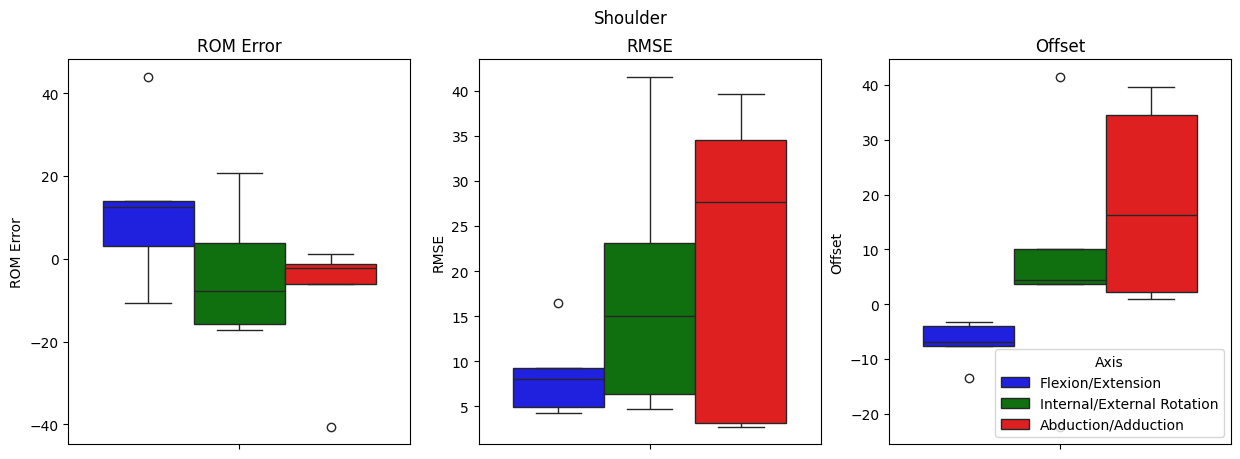

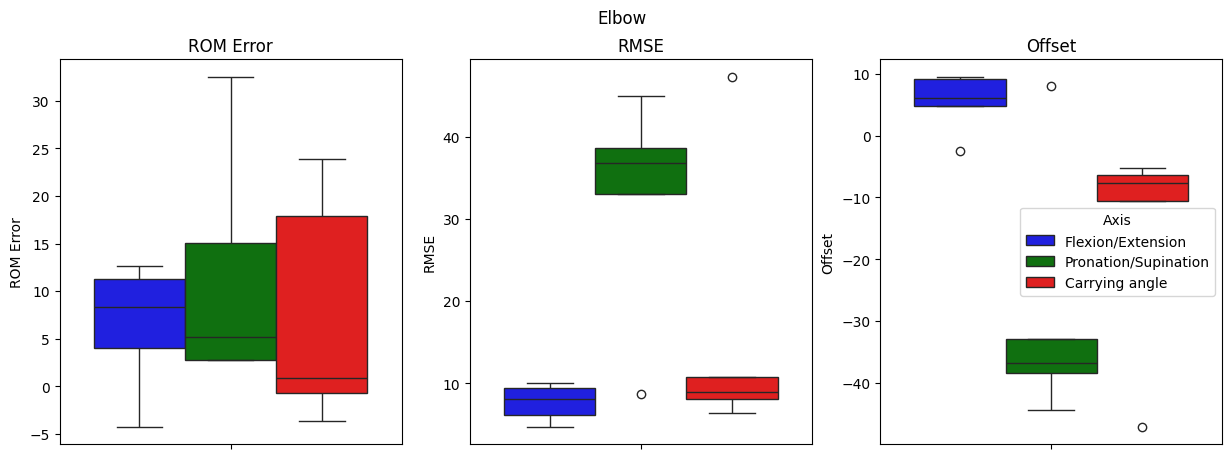

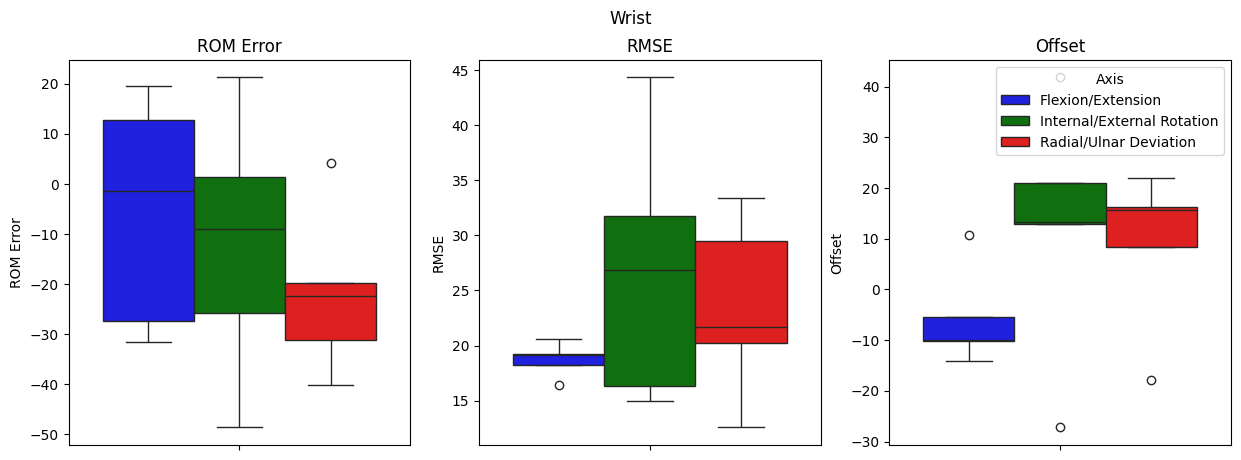

In [3]:
### Plot Metrics

var_names = ['ROM Error', 'RMSE', 'Offset']
legend_tag = [False, False, True]

for j in range(len(joints)):
    df = dataframe_list[j]
    fig, axList = plt.subplots(1,3, figsize=(15,5))
    
    for var in range(len(var_names)):
        
        sn.boxplot(data = df,  hue='Axis', y=var_names[var], palette=color_palette, ax=axList[var], legend=legend_tag[var])
        axList[var].set_title(var_names[var])
    fig.suptitle(joints[j])
    if j == 1:
        fig.savefig('Figures\\Elbow Metrics.svg', format='svg')
    